<div style="background-color: olive; padding: 40px; font-size: 40px;">
Forecasting
    
    
</div>

Practice forecasting using the following methods:

 - Last Observed Value
 - Simple Average
 - Moving Average
 - Previous Cycle
 - Holt's Linear Trend
 - Holt's Seasonal Trend

 - Acquire and prepare store sales data
 - Forecast future values using each modeling approach.
 - Evaluate competing model performance.


In [2]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import user, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

## Wrangle

Acquire the data from our MySQL server and cache a local .csv version of our data if it is not already present.

In [4]:
def get_db_url(database):
    '''
    Returns a formatted string using credentials stored in env.py that can be passed to a pd.read_sql() function
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [5]:
def get_store_data():
    '''
    Returns a dataframe of all store data in the tsa_item_demand database and saves a local copy as a csv file.
    '''
    if os.path.exists('tsa_store_data.csv'):
        df = pd.read_csv('tsa_store_data.csv')
    else:
        query = '''
                SELECT *
                FROM items
                JOIN sales USING(item_id)
                JOIN stores USING(store_id)
                '''

        df = pd.read_sql(query, get_db_url('tsa_item_demand'))
        df.to_csv('tsa_store_data.csv', index=False)
    return df

In [6]:
def wrangle_store_data():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'tsa_store_data.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = get_store_data()
    return df

In [7]:
df = wrangle_store_data()


In [8]:
df.head(2)


,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


## Prepare

 - 1 Convert the sale_date column to be a datetime type.
 - 2 Set index and sort values by date
 - 3 Rename sale_amount to quantity to make the two columns easier to understand what the data represents.
 - 4 Create a new field called sales_total that is the product of quantity and item_price.
 - 5 Confirm our approach using .head(), .info(), and .describe().
 - 6 Resample to a daily period.
 - 7 Drop the leap year days


## Preliminary Data Cleaning

In [9]:
[col for col in df.columns]


['store_id',
 'item_id',
 'item_upc14',
 'item_upc12',
 'item_brand',
 'item_name',
 'item_price',
 'sale_id',
 'sale_date',
 'sale_amount',
 'store_address',
 'store_zipcode',
 'store_city',
 'store_state']

In [10]:
def prep_store_data(df):
    '''
    Prepares raw store data for analysis and time series modeling.
    '''
    # convert the sale date to a datetime
    df.sale_date = pd.to_datetime(df['sale_date'])
    # make that value our index value
    df = df.set_index('sale_date').sort_index()
    #rename any messy columns that could get confusing:
    df = df.rename(columns={'sale_amount': 'quantity'})
    #engineer sales total by multiplying quantity by item price
    df['sales_total'] = df.quantity * df.item_price
    return df


In [11]:
df = prep_store_data(df)


In [12]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,quantity,store_address,store_zipcode,store_city,store_state,sales_total
sale_date,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,10.92
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,30.16
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,308.48
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,197.55
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,25.16


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   store_id       913000 non-null  int64  
 1   item_id        913000 non-null  int64  
 2   item_upc14     913000 non-null  int64  
 3   item_upc12     913000 non-null  int64  
 4   item_brand     913000 non-null  object 
 5   item_name      913000 non-null  object 
 6   item_price     913000 non-null  float64
 7   sale_id        913000 non-null  int64  
 8   quantity       913000 non-null  int64  
 9   store_address  913000 non-null  object 
 10  store_zipcode  913000 non-null  int64  
 11  store_city     913000 non-null  object 
 12  store_state    913000 non-null  object 
 13  sales_total    913000 non-null  float64
dtypes: float64(2), int64(7), object(5)
memory usage: 104.5+ MB


In [14]:
df.describe()


,store_id,item_id,item_upc14,item_upc12,item_price,sale_id,quantity,store_zipcode,sales_total
count,913000.000000,913000.000000,9.130000e+05,9.130000e+05,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,2.384688e+11,2.384688e+11,5.160400,456500.500000,52.250287,78224.800000,280.898866
std,2.872283,14.430878,2.978005e+11,2.978005e+11,2.737764,263560.542223,28.801144,16.479087,227.686575
min,1.000000,1.000000,8.500005e+09,8.500005e+09,0.600000,1.000000,0.000000,78201.000000,0.000000
25%,3.000000,13.000000,3.367410e+10,3.367410e+10,2.970000,228250.750000,30.000000,78217.000000,98.010000
50%,5.500000,25.500000,7.103651e+10,7.103651e+10,5.195000,456500.500000,47.000000,78220.500000,233.280000
75%,8.000000,38.000000,6.030842e+11,6.030842e+11,7.520000,684750.250000,70.000000,78232.000000,402.780000
max,10.000000,50.000000,8.846237e+11,8.846237e+11,9.640000,913000.000000,231.000000,78253.000000,2104.410000


## We will resample to daily aggregating our values using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores.

 -  lets examine this data in two different targets
 -  recall that time series interacts with a single Series
 -  or a univariate basis, so we are going to to examine two
 -  different forecasts
 -  I am interested in knowing for all of my stores,
 -  how does the total sales change over time
 -  and how does the volume change over time (quantity)

In [15]:
# resample by day, sum
# total of all quantities and total of all sales by day
df_resampled = df.resample('d')[
    ['quantity', 'sales_total']].sum()

In [16]:
df_resampled.head(2)


,quantity,sales_total
sale_date,,
2013-01-01,13696,73844.01
2013-01-02,13678,73570.58


In [17]:
df_resampled.shape


(1826, 2)

In [18]:
df_resampled.loc['2016-02-29']


quantity       16916.00
sales_total    90944.03
Name: 2016-02-29 00:00:00, dtype: float64

In [19]:
# Drop February 29th from our dataset (a leap year date)
# we do have a leap day in this data set, so going
# to drop it out so it doesn't disrupt our annual cycle/365 count
df_resampled = df_resampled[df_resampled.index != '2016-02-29']

In [20]:
df_resampled.head(2)


,quantity,sales_total
sale_date,,
2013-01-01,13696,73844.01
2013-01-02,13678,73570.58


## Split

 - We will use the training proportion method to split.
 - Identify the total length of the dataframe and multiple by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
 - Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
 - Return train and test dataframes.

Notes: "train_prop" method  ensures that time series model is trained on historical data and tested on future data, mimicking the real-world scenario where the predictions about future time points are based on past observations.

In [22]:
# multiplying dataframe by a proportion
# 50% of the data in this case
.5 * df_resampled.shape[0]

912.5

In [23]:
# round that value so we can use it as a number of rows
int(.5 * len(df_resampled))

912

In [24]:
# take 50% of our data for train (round to integer for a whole number)
train_size = int(.5 * len(df_resampled))
# take 30% for validation
validate_size = int(len(df_resampled) * .3)
# get the remainder or rows for test
test_size = int(len(df_resampled) - train_size - validate_size)
# get the delineation point between validate and test by summing train and validate
validate_end_index = train_size + validate_size

# split into train, validation, test
# use everything up to train size (noninclusive because no loc)
train = df_resampled[:train_size]
# use from train size up to validate end size -> train_size + validate_size
validate = df_resampled[train_size:validate_end_index]
# test: from the validation end to the end of the df
test = df_resampled[validate_end_index:]


In [25]:
# how do I know that I captured everything?
# we can check that the sum of our sets is equivalent to the sum
# of our resampled dataframe (1825) (after dropping leap day)
train.shape[0] + validate.shape[0] + test.shape[0]

1825

In [26]:
pd.concat([train.tail(1),
validate.head(1)], axis=0, ignore_index=False)

,quantity,sales_total
sale_date,,
2015-07-01,30703,164573.20
2015-07-02,33134,178036.64


## Visualizing Our Data

Let's plot our data first, viewing where the data is split into train and test.



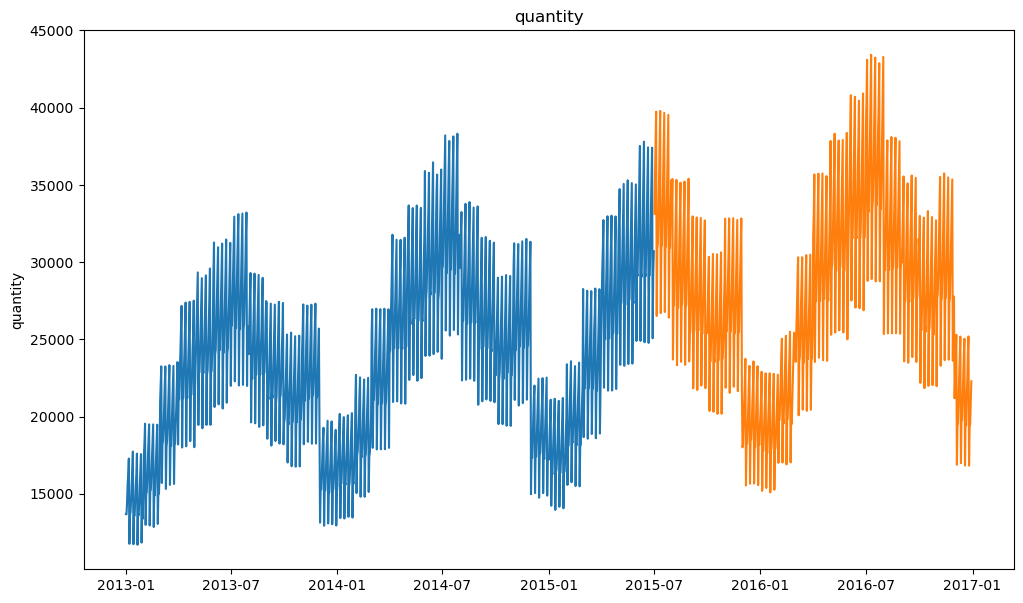

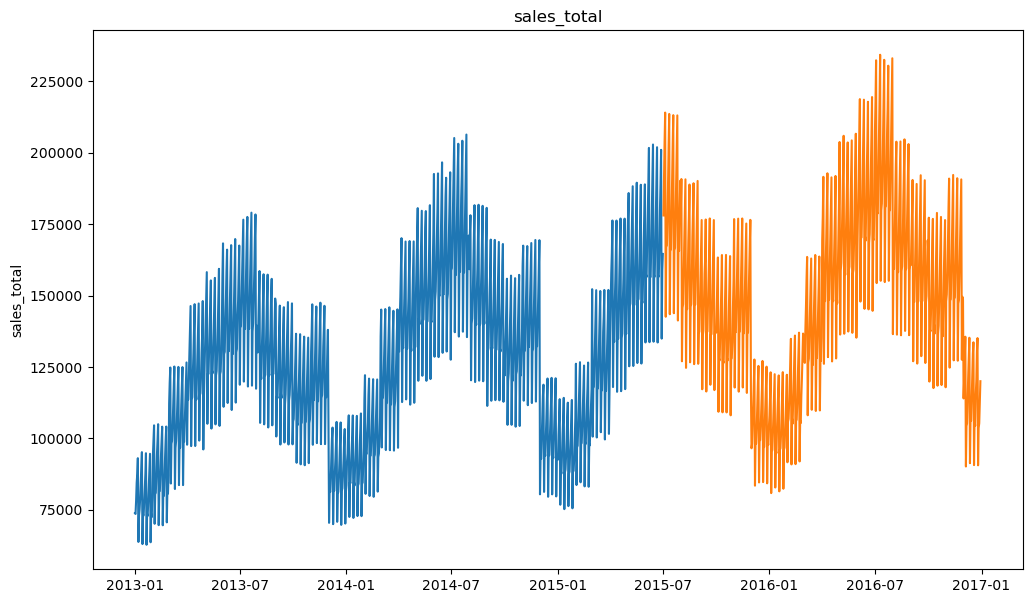

In [27]:
# plotting the values of quantity and sales over time by data subset:
# since we are dealing with two targets,
# lets plot train val and test twice
# once for each target
for col in train.columns:
    plt.figure(figsize=(12,7))
    plt.plot(train[col])
    plt.plot(validate[col])
    # plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Creating Helpful Evaluation Functions

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

evaluate() will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [28]:
yhat_df = pd.DataFrame()


In [29]:
# evaluation function to compute rmse
# calculate an error metric on the validation's target versus predictions
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    # calculate a root mean squared error 
    # using our validate information and
    # a yhat_df
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to visualize our performance to make comparisons.



In [30]:
# plot and evaluate 
def plot_and_eval(target_var,
                 train=train):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    #plot out the train values (the real ones)
    plt.plot(train[target_var], label='Train', linewidth=1)
    # plot out the real validate values
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    # compare our information on the validation set's projections
    plt.plot(yhat_df[target_var], linewidth=1)
    # title our plot
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.show()

We are planning on evaluating a lot of models. Let's create an easy to read dataframe called eval_df. We will eventually add the metrics we calculate for each of our models to this dataframe for easy comparison.

In [31]:
# Create the empty dataframe
# eval_df is an empty dataframe for now,
# it will contain the names of our forecasting methods,
# the target variable that its predicting,
# and the error associated with that specific model
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [ ]:
# we will have a dataframe that we can narrow down to a specific
# model type, so if I want the best model by error value
# specifically for my quantity model,
# i could take eval_df.groupby(model_type).rmse.min()

While we could manually append the performance results of each model to this dataframe, its better to create a function that will do it for us.

append_eval_df() will append evaluation metrics for each model into our eval_df data frame object. This function is dependent on eval_df already existing, which we accomplished in our previous step.

In [32]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    # invoke our evaluate function from above, which returns
    # a single rmse value
    rmse = evaluate(target_var)
    #build a single row with a dictionary structure
    # that conains the contents that we initialized for our eval_df
    # turn that dictionary into a dataframe (single row)
    #concat it into our eval_df, adding this new row of metrics
    # to our dataframe
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)], ignore_index=True)

In [33]:
pd.DataFrame({'a':[0,1,2], 'b': ['ham','sand','wich']})


,a,b
0,0,ham
1,1,sand
2,2,wich


In [34]:
pd.DataFrame({'model_type': ['holts'], 'rmse':[2874.5]})


,model_type,rmse
0,holts,2874.5


## Forecast

Forecasting is another word for predicting time series data. As a reminder, we will work with the following approaches:



 - Baseline Models
  - 1. Last Observed Value
  - 2. Simple Average
  - 3. Moving Average
 - Non-Baseline Models
  - 4. Previous Cycle
  - 5. Holt's Linear Trend
  - 6. Holt's Seasonal Trend

## Last Observed Value
The simplest method for forecasting is to predict all future values to be the last observed value.


## Make Predictions



In [35]:
train['sales_total'][-1:][0]


164573.2

In [36]:
# going forward from the -1st element in train's sales total, then 
# rip out the value associated with it by taking the zeroth element of that return
train['sales_total'][-1]


164573.2

In [38]:
# take the last item of sales total and assign to variable
# indexing: last thing to the end, then the first element
last_sales = train['sales_total'][-1:][0]

# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]

# let's make the prediction dataframe that we referenced a little earlier
yhat_df = pd.DataFrame(
    {
    'sales_total': [last_sales],
    'quantity': [last_quantity]
    },
    # we pass the same index as our validation set
    #this is critical for two reasons:
    # one: we need the validation set to be the same size for error predictions
    # two: we need the dates to match up for mapping our forecasting
    # to the right window of time
    index = validate.index
)

In [39]:
yhat_df.head()


,sales_total,quantity
sale_date,,
2015-07-02,164573.2,30703
2015-07-03,164573.2,30703
2015-07-04,164573.2,30703
2015-07-05,164573.2,30703
2015-07-06,164573.2,30703


You can see, when peeking into yhat_df, that every predicted value is the same.

## Plot Actual vs. Predicted Values

Now, let's plot actual and predicted values using our plot_and_eval() function:



In [40]:
train.columns


Index(['quantity', 'sales_total'], dtype='object')

In [41]:
yhat_df


,sales_total,quantity
sale_date,,
2015-07-02,164573.2,30703
2015-07-03,164573.2,30703
2015-07-04,164573.2,30703
2015-07-05,164573.2,30703
2015-07-06,164573.2,30703
...,...,...
2016-12-26,164573.2,30703
2016-12-27,164573.2,30703
2016-12-28,164573.2,30703


In [44]:
train.columns


Index(['quantity', 'sales_total'], dtype='object')

In [45]:
validate.columns


Index(['quantity', 'sales_total'], dtype='object')

quantity -- rmse: 6621.0


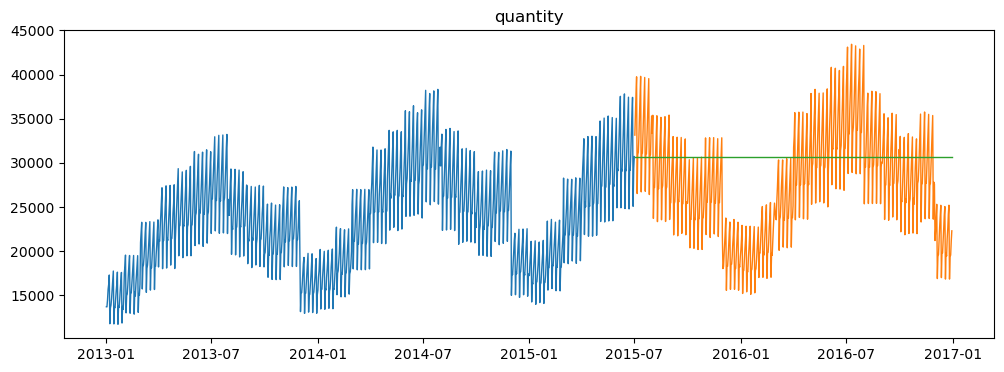

sales_total -- rmse: 35402.0


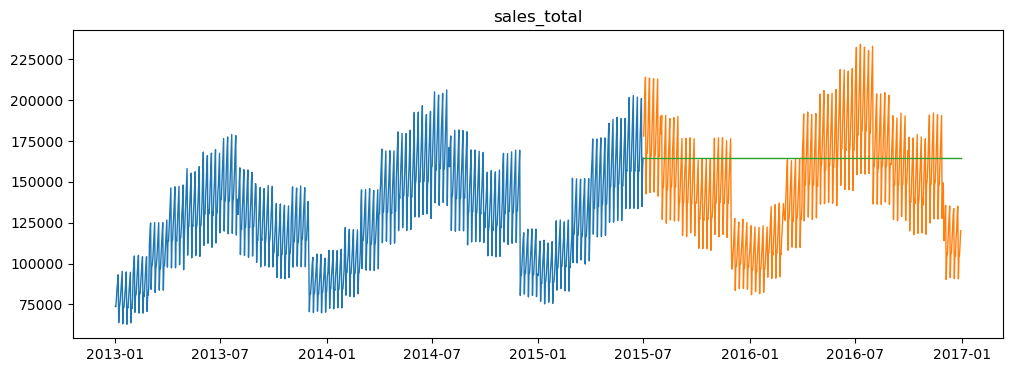

In [46]:
# use the plot and eval function we defined earlier for both targets:
for col in train.columns:
    plot_and_eval(col)

## Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df. We will add our metrics via our append_eval_df() function.



In [47]:
# establish our blank eval_df
eval_df

,model_type,target_var,rmse


In [48]:
# do append_eval_df twice,
# once for each target,
# which are the two columns in our train
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                             target_var=col)

In [49]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
1,last_observed_value,sales_total,35402.0


## Simple Average


Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.



## Make Predictions



In [50]:
# simple average is very similar to what we saw with last observed
# value and what we have seen with baselines for regression
# take the target from our training set,
# take the mean(), pass that as our new prediction
# this is still going to be a flatline forecast
# compute simple average of sales_total (from train data)
avg_sales = round(train['sales_total'].mean(), 2)

# compute simple average of quantity (from train data)
avg_quantity = round(train['quantity'].mean(), 2)

# repeat the construction of a yhat_df
# note that we are creating it wholecloth again
# instead of adding these columns to the one that already exists
# the structure of our evalutation
# and plotting functions
# is contingent on having a yhat_df
# that reflects the current predictions that we want to know
# the metrics of, which then pass to our eval_df
yhat_df = pd.DataFrame({'sales_total': [avg_sales],
                        'quantity': [avg_quantity]},
                        index=validate.index)

yhat_df.head(3)

,sales_total,quantity
sale_date,,
2015-07-02,127517.85,23717.94
2015-07-03,127517.85,23717.94
2015-07-04,127517.85,23717.94


## Plot Actual vs. Predicted Values

Similar to our handling of the previous baseline model, we can plot our yhat_df values against the actual values in validate. Our plot_and_eval function accomplishes this.

quantity -- rmse: 7378.0


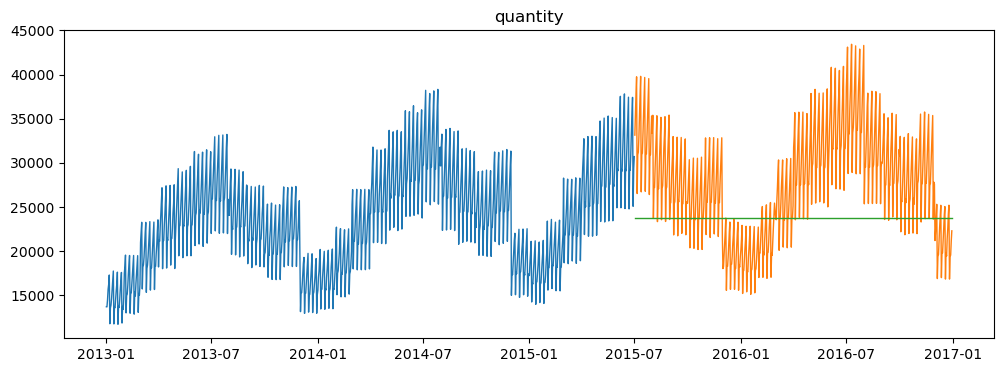

sales_total -- rmse: 39664.0


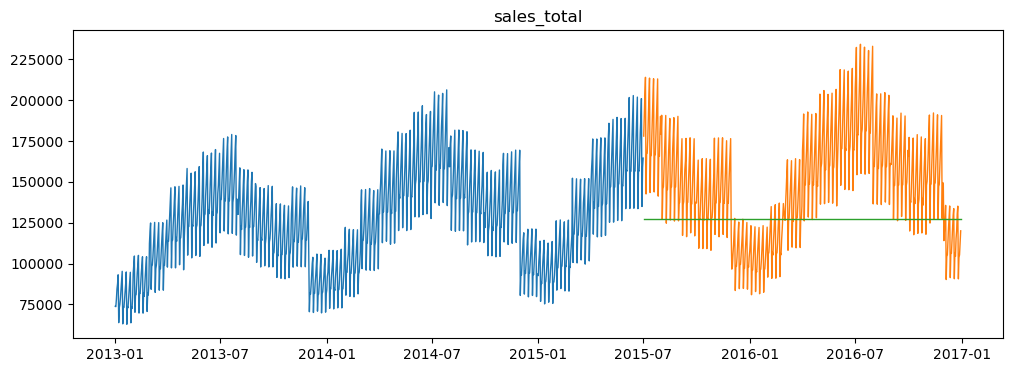

In [51]:
for col in train.columns:
    plot_and_eval(col)

## Evaluate

In [ ]:
Evaluate using MSE and RMSE, and add evaluation metrics to eval_df



In [52]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
1,last_observed_value,sales_total,35402.0
2,simple_average,quantity,7378.0
3,simple_average,sales_total,39664.0


## Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average of the last period, here 30-days, will be used as the forecasted value.

Moving averages are moving and change over time, but only historically. Forecasts using the moving average use the average of the last period/window of time.

moving average forecast diagram

## Make Predictions



There are several ways to obtain the mean of the last 30 periods in train. We will use the .rolling() method to accomplish this.



In [53]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

# we have resampled by day,
# which means that if we want a 30 day rolling average
# we want to pass the rolling method with 30
# as the argument, specifying the rolling mean()
# and just like with last observed value,
# we take the last entry, denoted by the indexing of [-1]
rolling_sales = round(
    train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(
    train['quantity'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

#create a yhat_df again with the new values
yhat_df = pd.DataFrame({'sales_total': rolling_sales,
                        'quantity': rolling_quantity},
                         index=validate.index)
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-02,168957.91,31432.77
2015-07-03,168957.91,31432.77
2015-07-04,168957.91,31432.77
2015-07-05,168957.91,31432.77
2015-07-06,168957.91,31432.77


## Plot Actual vs. Predicted Values



Now, let's plot and evaluate the performance of our time series model using Moving Average



quantity -- rmse: 6954.0


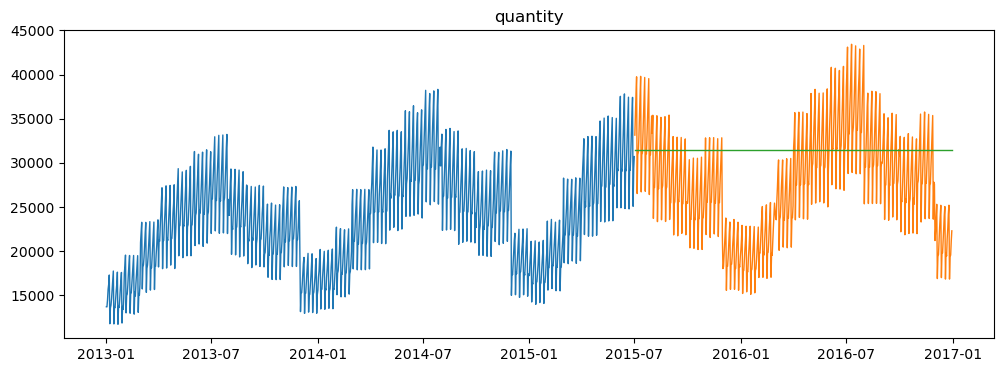

sales_total -- rmse: 37378.0


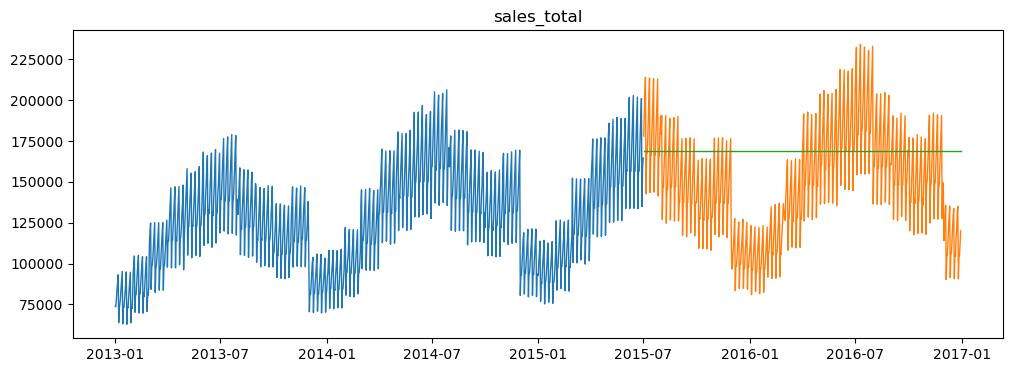

In [55]:
# gaze with wonder upon my failures
for col in train.columns:
    plot_and_eval(col)

## Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df



In [56]:
# same process here:
# for every column in my train -> [quantity, sales]
for col in train.columns:
    # make a row of info for each target,
    # append those values
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
1,last_observed_value,sales_total,35402.0
2,simple_average,quantity,7378.0
3,simple_average,sales_total,39664.0
4,30d moving average,quantity,6954.0
5,30d moving average,sales_total,37378.0


Let's try out several other values for periods:



In [57]:
periods = [4, 12, 26, 52, 104]

# try out a few different rolling averages
# for each value in periods:
for p in periods: 
    # calculate a new rolling average like we did last time,
    # take that single value
    rolling_sales = round(
    train['sales_total'].rolling(p).mean()[-1], 2)
    # do the same thing for quantity
    rolling_quantity = round(
    train['quantity'].rolling(p).mean()[-1], 2)
    #create a new yhat df each time in the loop
    yhat_df = pd.DataFrame(
        {
            'sales_total' : [rolling_sales],
            'quantity': [rolling_quantity]
        },
        index=validate.index
    )
    # use a new string for model type,
    # build off of the str(period) concatenated with _day_mving_avg
    model_type = str(p) + '_day_moving_avg'
    # lets update the eval_df (remember we have two targets!)
    # subloop: make a row for each prediction in eval_df
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col)

In [58]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
1,last_observed_value,sales_total,35402.0
2,simple_average,quantity,7378.0
3,simple_average,sales_total,39664.0
4,30d moving average,quantity,6954.0
5,30d moving average,sales_total,37378.0
6,4_day_moving_avg,quantity,6592.0
7,4_day_moving_avg,sales_total,35515.0
8,12_day_moving_avg,quantity,6992.0
9,12_day_moving_avg,sales_total,37644.0


In [ ]:
Which is best so far?



In [59]:
eval_df.groupby('target_var')['rmse'].min()


target_var
quantity        6101.0
sales_total    32803.0
Name: rmse, dtype: float64

In [60]:
# get the min rmse for each variable
min_rmse_sales_total = eval_df.groupby(
    'target_var')['rmse'].min()[1]
min_rmse_quantity = eval_df.groupby(
    'target_var')['rmse'].min()[0]


In [61]:
min_rmse_sales_total


32803.0

In [62]:
eval_df[(eval_df.rmse == min_rmse_sales_total) | 
       (eval_df.rmse == min_rmse_quantity)]

,model_type,target_var,rmse
14,104_day_moving_avg,quantity,6101.0
15,104_day_moving_avg,sales_total,32803.0


As far as baselines are concerned, it looks like our 104 day moving average is a good starting point for comparisons.



## Non-Baseline Models

## Holt-Winters

Two of the models that we will evaluate are based on Holt-Winters, which models on three elements:

A typical value (average)
A slope (trend) over time
And a cyclical repeating pattern (seasonality)
Its worth looking at a seasonal decomposition plot of our target, to inspect these components:



## Seasonal Decomposition

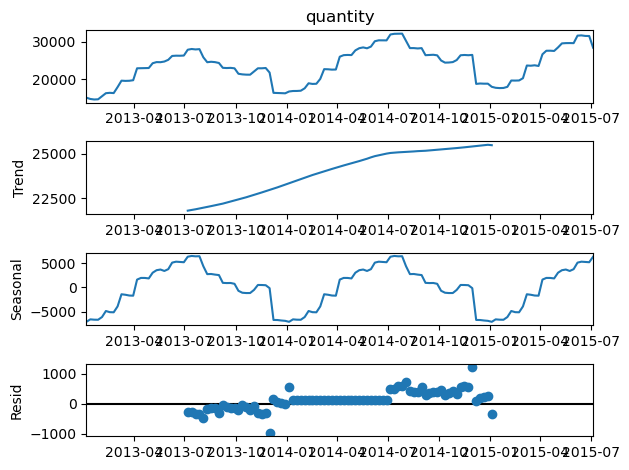

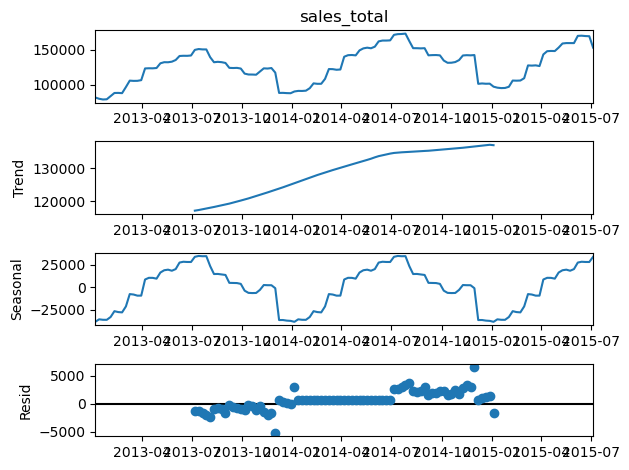

In [63]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

In [ ]:
It looks like there is both strong seasonality and a notable trend in both targets (sales_total and quantity). There are two Holt-Winters models that we will attempt

Holt's Linear Trend
Holt's Seasonal Model

## Holt's Linear Trend

Our approach will be similar to many other modeling processes we have performed:

Create the object: Holt()
Fit the object: .fit()
Make predictions: .predict()


 - The first set of hyperparameters are set when we call Holt():

exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
damped 
 = True/False
with Holt, forecasts tend to increase or decrease indefinitely into the future. To avoid absurd long term predictions, use the Damped method (True) which sets a damping parameter between 0< ϕ <1.
 - A second set of hyperparameters are set when we call .fit():

smoothing_level (
): value between (0,1)
Closer to 0, the level doesn't change with each new observation
Closer to 1, the level reacts strongly with each new observation
smoothing_slope (
): value between (0,1)
Closer to 0, trend is not changing over time
Closer to 1, trend is changing significantly over time
optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

## Basic Holt's Linear Trend
diagram of holts linear trent

### Make Predictions

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.




In [65]:
for col in train.columns:
    # for each target variable that we have:
    # make the thing:
    # notably: we pass the training set into the creation
    # so rather than making an empty model object and passing
    # the values in fit,
    # the values are passed in the initialization,
    # and we merely have the training set baked in when we call
    # fit
    model = Holt(train[col], exponential=False, damped=True)
    # fit the model
    model = model.fit(optimized=True)
    # predict:
    # we pass starting and ending indeces to our predict
    #which means that we start at our first validate index value -> 0
    # and continue until the end of the validation set [-1]
    yhat_values = model.predict(start=validate.index[0],
                                end= validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [66]:
yhat_df.head()


,sales_total,quantity
sale_date,,
2015-07-02,170207.53,31656.49
2015-07-03,170328.01,31678.93
2015-07-04,170447.29,31701.15
2015-07-05,170565.37,31723.15
2015-07-06,170682.27,31744.93


## Plot Actual vs. Predicted Values



quantity -- rmse: 8225.0


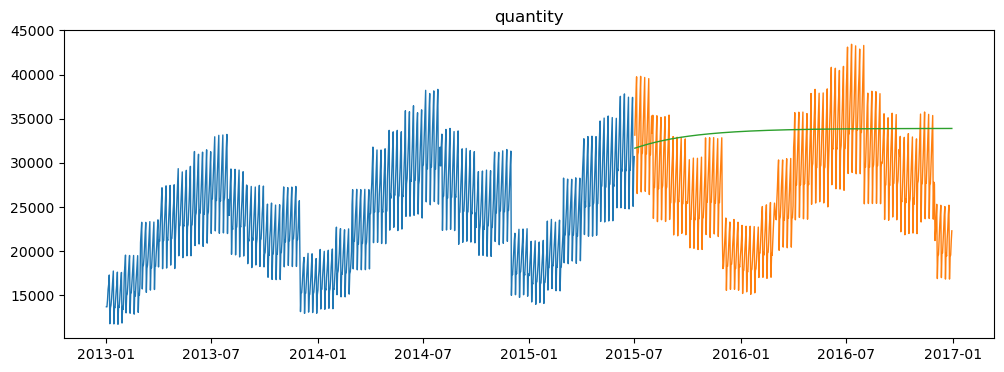

sales_total -- rmse: 44226.0


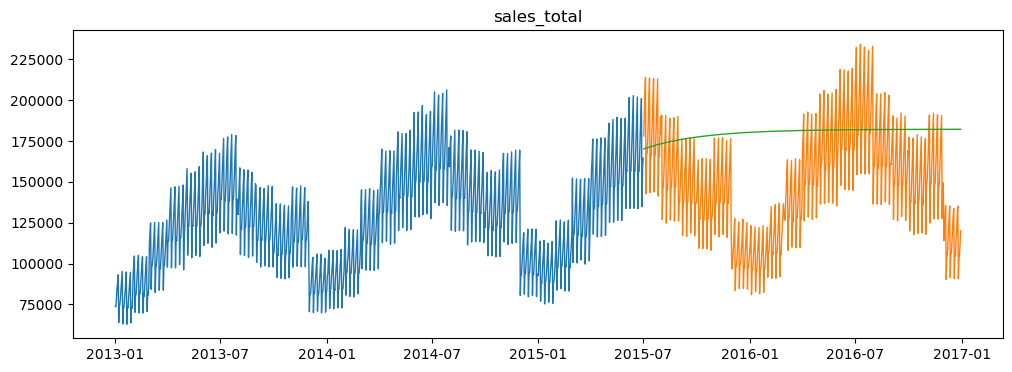

In [67]:
for col in train.columns:
    plot_and_eval(target_var = col)

## Evaluate



In [69]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

# Holt's Seasonal Trend

Holt's Seasonal Trend is started by using ExponentialSmoothing()

The process is similar to our previous model:

  1 Create the object: ExponentialSmoothing()
  2  Fit the object: .fit()
  3 Make predictions: .forecast()
This function has several hyperparameters:

 - seasonal_periods: The number of periods representing one cycle of seasonality. This is why performing a decomposition plot can be valuable, as this number needs to be entered manually.
 - trend: Whether the overall trend is additive (trend='add') or multiplicative (trend='mul')
 - seasonal: Whether the seasonality is additive (seasonal='add') or multiplicative (seasonal='mul')
 - damped: If we want the trend to reduce over the length of the forecast to avoid absurd long term predictions, we can set damped=True
 
 
Given our smaller dataset, rather than choosing any one combination of hyperparameters, we can create multiple models to test different combinations:

Quantity
model_name	seasonal_periods	trend	seasonal	damped
hst_quantity_fit1	365	add	add	False
hst_quantity_fit2	365	add	mul	False
hst_quantity_fit3	365	add	add	True
hst_quantity_fit4	365	add	mul	True


Sales Total
model_name	seasonal_periods	trend	seasonal	damped
hst_sales_fit1	365	add	add	False
hst_sales_fit2	365	add	mul	False
hst_sales_fit3	365	add	add	True
hst_sales_fit4	365	add	mul	True

In [70]:
import itertools

In [71]:
combos = list(itertools.product(['add','mul'],[True, False]))


In [72]:
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [73]:
# let's play with some hyperparameter combinations:
# initialize an empty dictionary for our models:
hsts = {}
# outer loop: for each target:
for col in train.columns:
    # create a new dictionary for this specific target
    hsts[col] = {}
    # for every index and hyperparam combo:
    #create a new entry for this target
    # that refers to a specific fit model
    for i, combo in enumerate(combos):
        # create the exponential smoothing object
        #note we use the training set in the same way as above
        hsts[col]['hst_fit_' + str(i)] = \
        ExponentialSmoothing(train[col],
                            seasonal_periods=365,
                            trend='add',
                            seasonal=combo[0],
                            damped=combo[1]).fit()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(

In [74]:
hsts.keys()


dict_keys(['quantity', 'sales_total'])

In [75]:
hsts['sales_total']


{'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x177cebe10>,
 'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x177cfe7d0>,
 'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x177d0d410>,
 'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x177d17c90>}

In [76]:
# compare our scores
# lets crank through those models
# and campare how they did to eachother
best_score = 'placeholder'
# hold best score as a placeholder
for model in hsts['quantity']:
    # for each model associated with this target:
    #calculate the error (sse)
    score = sqrt(hsts['quantity'][model].sse / len(train))
    # new dictionary for current model, associated with the value
    # for the score
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

In [77]:
best_score


{'hst_fit_1': 3159.366982354296}

In [78]:
best_score = 'placeholder'
for model in hsts['sales_total']:
    score = sqrt(hsts['sales_total'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] \
        > list(current_model.values())[0]:
            best_score = current_model

In [79]:
best_score


{'hst_fit_1': 16968.01699896696}

The model contains a SSE attribute that we can use to compare performance. We can derive RMSE from SSE, but for now, we can just use SSE to look at the relative performance of our Holt's Seasonal Trend models.

In [80]:
best_score= 'placeholder'
for model in hsts['sales_total']:
    score = (hsts['sales_total'][model].sse / len(train)) ** .5
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

## Make Predictions

The .forecast() method for Holt's Seasonal models requires the number of periods the model is going to provide a prediction for after the end of the training data.

In [81]:
train.shape, validate.shape, test.shape


((912, 2), (547, 2), (366, 2))

In [82]:
validate.head(1)


,quantity,sales_total
sale_date,,
2015-07-02,33134,178036.64


In [83]:
# reference the object directly from the dictionary
# use that to forecast
# note that forecast is passed slightly different here:
# validate's number of rows plus one
hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + 1)

2015-07-02    30633.609157
2015-07-03    30824.375920
2015-07-04    32601.133135
2015-07-05    34413.198903
2015-07-06    36222.829247
                  ...     
2016-12-26    23487.970861
2016-12-27    24825.313369
2016-12-28    24089.851561
2016-12-29    19458.764042
2016-12-30    21134.563024
Freq: D, Length: 548, dtype: float64

In [84]:
yhat_df = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + 1),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + 1)},
                          index=validate.index)
yhat_df


,sales_total,quantity
sale_date,,
2015-07-02,164502.281911,30633.609157
2015-07-03,165569.185324,30824.375920
2015-07-04,174779.724683,32601.133135
2015-07-05,184256.646897,34413.198903
2015-07-06,194791.243951,36222.829247
...,...,...
2016-12-26,123765.793979,23487.970861
2016-12-27,130341.439092,24825.313369
2016-12-28,126861.790883,24089.851561


quantity -- rmse: 4869.0


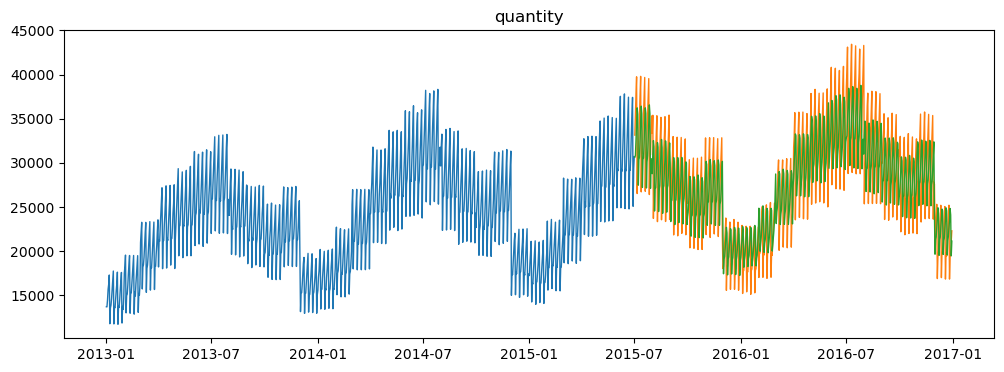

sales_total -- rmse: 26294.0


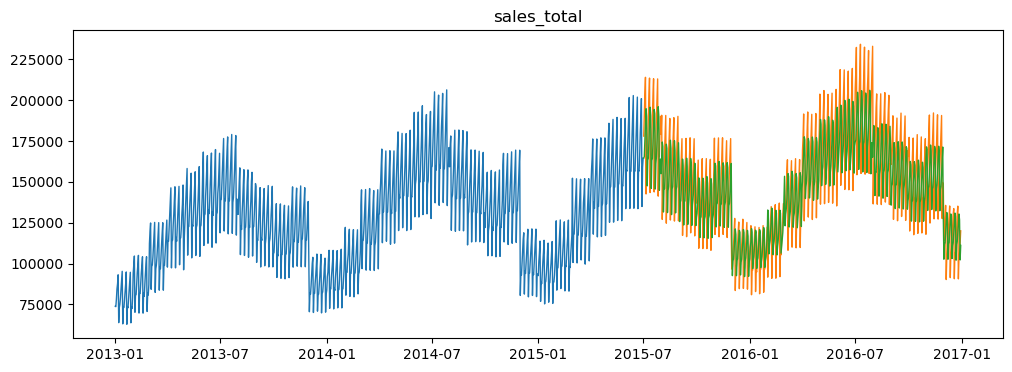

In [85]:
for col in train.columns:
    plot_and_eval(col)

In [86]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [87]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
20,holts_seasonal,quantity,4869.0
14,104_day_moving_avg,quantity,6101.0
12,52_day_moving_avg,quantity,6563.0
6,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
4,30d moving average,quantity,6954.0
8,12_day_moving_avg,quantity,6992.0
10,26_day_moving_avg,quantity,7004.0
2,simple_average,quantity,7378.0
16,holts_optimized,quantity,8225.0


quantity -- rmse: 4869.0


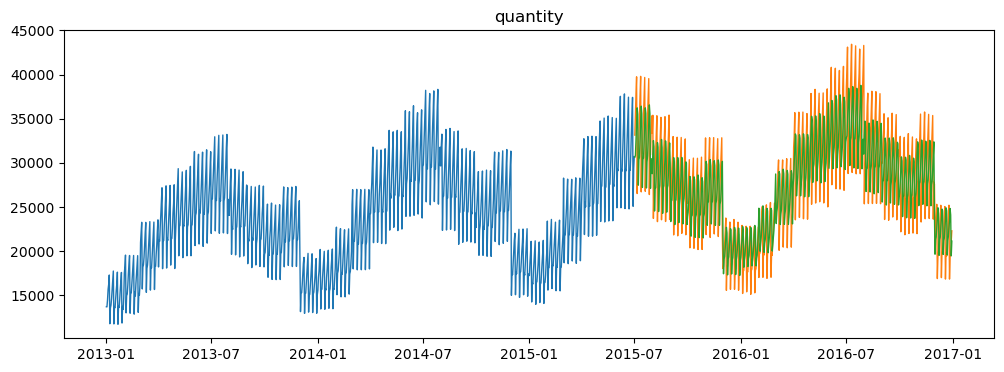

sales_total -- rmse: 26294.0


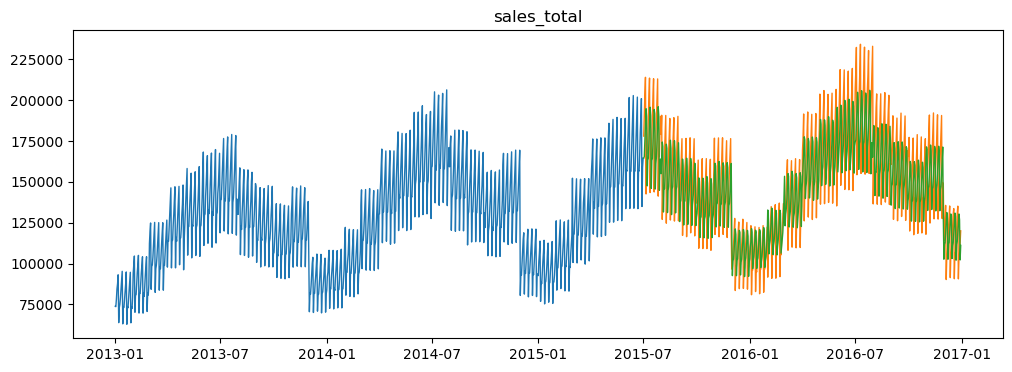

In [88]:
for col in train.columns:
    plot_and_eval(col)

In [89]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [90]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
20,holts_seasonal,quantity,4869.0
22,holts_seasonal,quantity,4869.0
14,104_day_moving_avg,quantity,6101.0
12,52_day_moving_avg,quantity,6563.0
6,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
4,30d moving average,quantity,6954.0
8,12_day_moving_avg,quantity,6992.0
10,26_day_moving_avg,quantity,7004.0
2,simple_average,quantity,7378.0


Our best implementation of Holt's Seasonal Trend is significantly outperforming all other models made thus far.



# Predict Based on Previous Cycle


Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

diagram of forecasting with previous cycle

In the below example:

Compute the 365 average year over year differences from 2013 through 2015
Add that average delta to the values during 2015.
Set the index in your yhat dataframe to represent the dates those predictions are make for.
Let's get started....



## Re-split data



In [93]:
# split it up by year
train = df_resampled.loc[:'2015']
validate = df_resampled.loc['2016']
test = df_resampled.loc['2017']

## Make Predictions



In [94]:
# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015.
# grab the contents from 2015,
# add a year's average to them to capture some upward linear trend
yhat_df = train.loc['2015'] + train.diff(365).mean()

# set yhat_df to index of validate
yhat_df.index = validate.index

In [95]:
yhat_df.head()


,quantity,sales_total
sale_date,,
2016-01-01,19411.813699,104337.620493
2016-01-02,20904.813699,112870.770493
2016-01-03,21983.813699,118245.300493
2016-01-04,23286.813699,125496.760493
2016-01-05,16420.813699,88551.940493


## Plot and Evaluate



In [96]:
train.tail()


,quantity,sales_total
sale_date,,
2015-12-27,23268,125125.86
2015-12-28,15569,84297.45
2015-12-29,18403,98602.75
2015-12-30,18191,97773.10
2015-12-31,19377,103969.42


In [97]:
validate.head()


,quantity,sales_total
sale_date,,
2016-01-01,20158,107875.26
2016-01-02,21280,114330.43
2016-01-03,22911,123144.91
2016-01-04,15199,80873.97
2016-01-05,17806,95429.90


quantity -- rmse: 5223.0


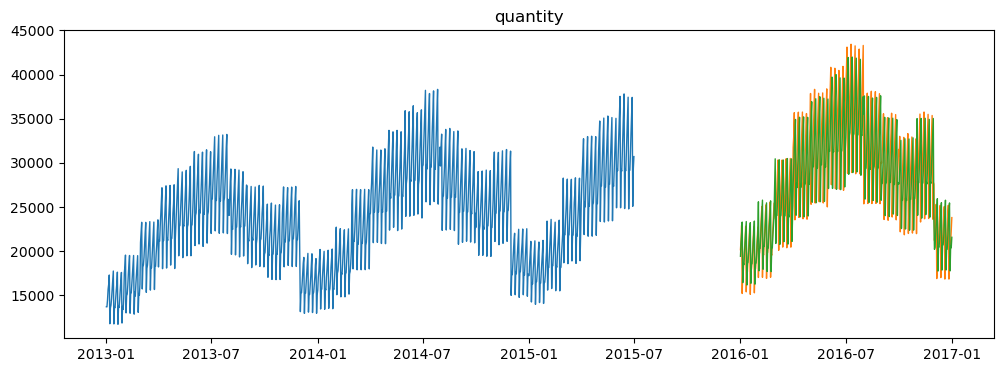

sales_total -- rmse: 28087.0


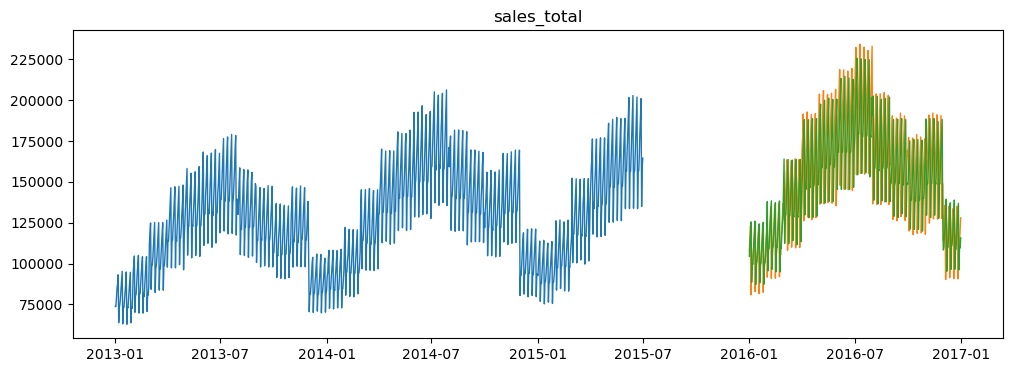

In [98]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

# Conclusion

In [ ]:
Which model did the best?



In [99]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
22,holts_seasonal,quantity,4869.0
20,holts_seasonal,quantity,4869.0
24,previous year,quantity,5223.0
14,104_day_moving_avg,quantity,6101.0
12,52_day_moving_avg,quantity,6563.0
6,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
4,30d moving average,quantity,6954.0
8,12_day_moving_avg,quantity,6992.0
10,26_day_moving_avg,quantity,7004.0


In [100]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

,model_type,target_var,rmse
20,holts_seasonal,quantity,4869.0
21,holts_seasonal,sales_total,26294.0
22,holts_seasonal,quantity,4869.0
23,holts_seasonal,sales_total,26294.0


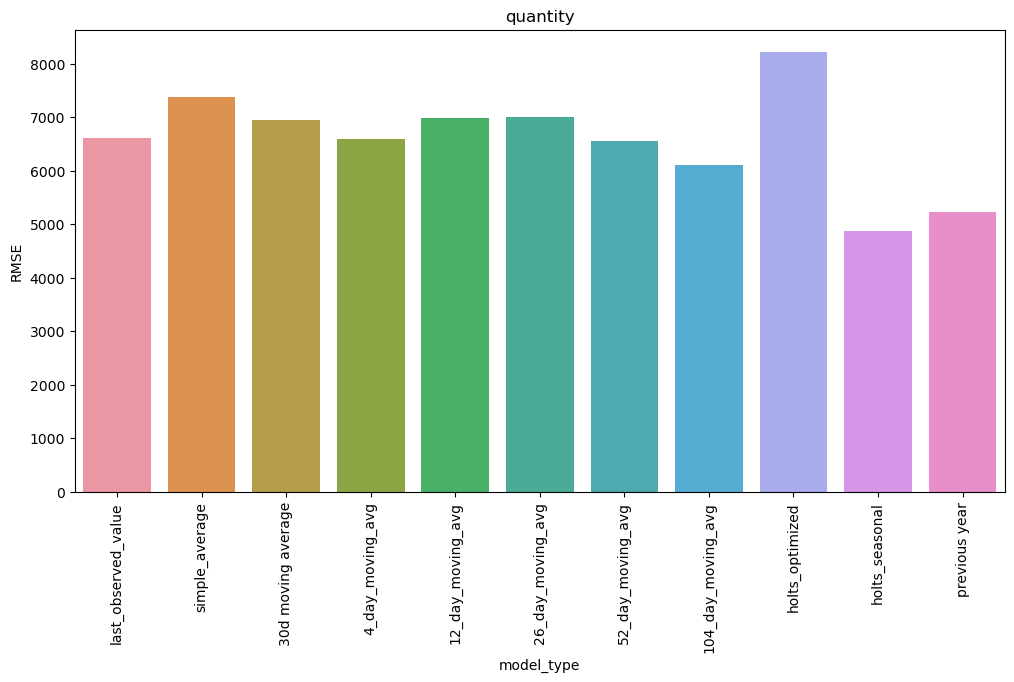

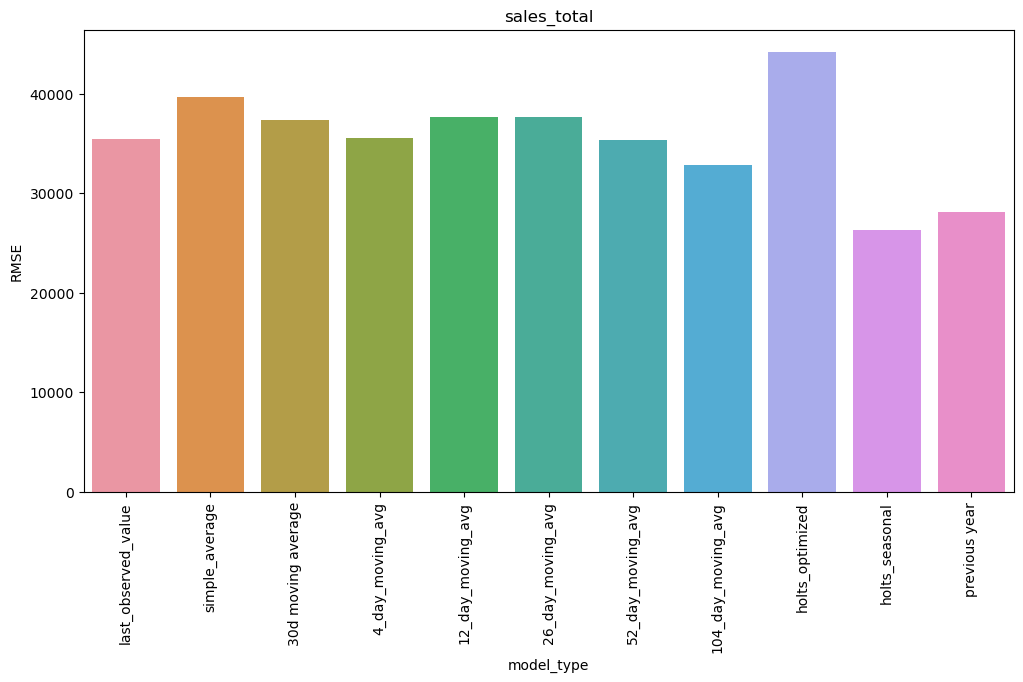

In [101]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x, y=y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.show()

## Performance on Test

Now that we have identified our one best model for each target variable, we can evaluate its peformance on our test data. As a reminder, .forecast() allows us to make predictions, but the method always starts after the end of the training data. To get to the test data, we will need to increase the number of periods being predicted to be equal to the combined periods of validate and test.

We altered our train-validate-test split to perform the previous cycle approach. Let's reset to the original train-validate-test split.

In [102]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]
train.shape, validate.shape, test.shape


((912, 2), (547, 2), (366, 2))

In [103]:
yhat_df = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1)})
yhat_df

,sales_total,quantity
2015-07-02,164502.281911,30633.609157
2015-07-03,165569.185324,30824.375920
2015-07-04,174779.724683,32601.133135
2015-07-05,184256.646897,34413.198903
2015-07-06,194791.243951,36222.829247
...,...,...
2017-12-27,140412.035600,27040.540472
2017-12-28,136932.387391,26305.078664
2017-12-29,112264.606974,21673.991145
2017-12-30,121152.222108,23349.790128


The original test set started on 2016-12-31, so we can slice out that portion from our yhat_df:



In [104]:
yhat_df = yhat_df['2016-12-31':]


In [105]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-sales total:  29582.62913210876
rmse-quantity:  5600.367125634174


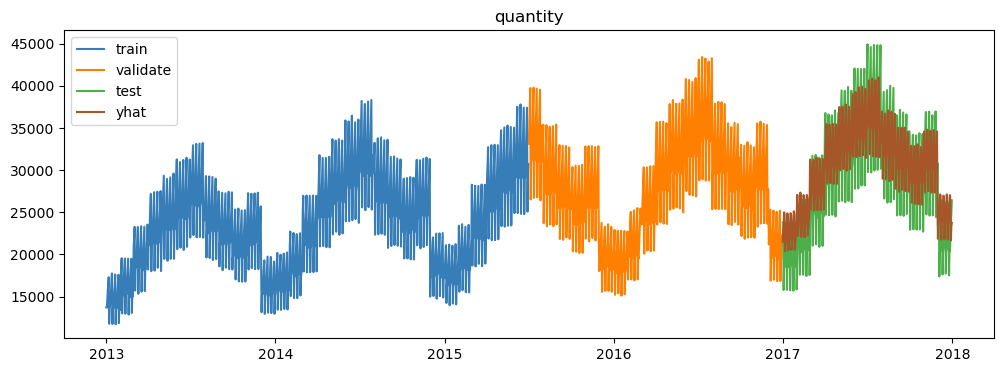

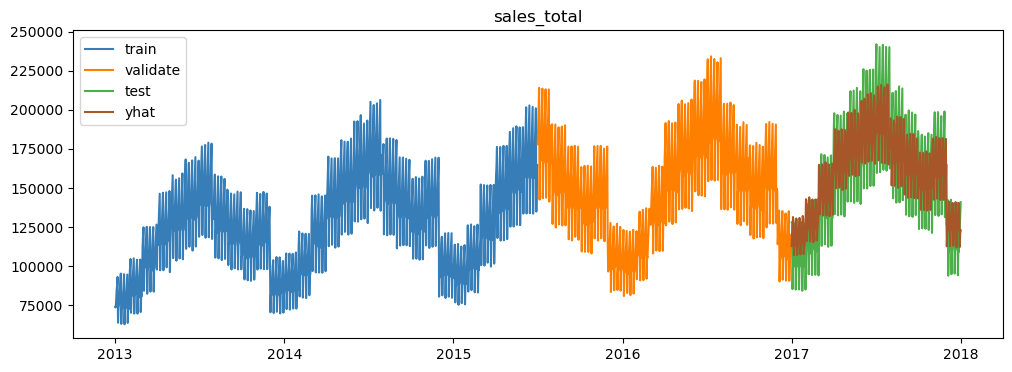

In [106]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)
for col in train.columns:
    final_plot(col)

Our RMSE of our final model did get noticably worse on the test data. Its possible that while the performance of the model starts high, it degrades the further out it projects. Let's take a look at what a projection into 2018 would look like.

# Forcasting Into Future

Predicting 2018 simply requires us to extend the value passed to .forecast() by an additional 365 periods and then slicing out what we want:

In [107]:
forecast = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1 + 365),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1 + 365)})
# how does forecast look

In [108]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

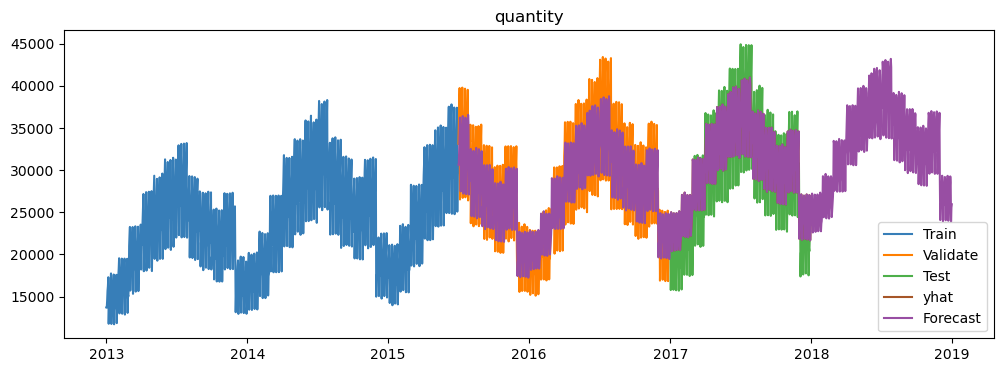

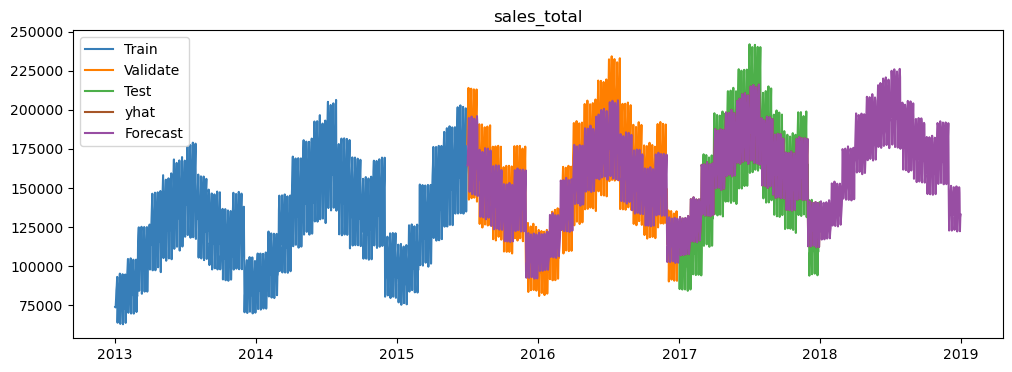

In [109]:
for col in train.columns:
    final_plot(col)

This data set was made of synthetic data with a clear and observable pattern. It allows us to observe the risk of long term performance degredation. While Holt's Seasonal Trend outperformed Previous Cycle on validate, Previous Cycle would have probably been the best model to use. Holt's Seasonal Trend is failing to demonstrate the higher maximum value in each subsequent cycle.



However, I can be confident in this claim because I have atypical knowledge that this data is extremely predictable. Real data is rarely as reliable, and conclusions are rarely as clear as the example we have shown here.

Forecasting is an art as much as it is a science, as the environment that created the values of our historical data may be very different from the environment that creates future values.

"It's tough to make predictions, especially about the future." - Yogi Berra



# Further Resources
### Modeling with SARIMAX
### Modeling with SVR
### The Prophet model from Facebook


In [ ]:
Exercises
The end result of this exercise should be a Jupyter notebook named model.

Using saas.csv or log data from API usage

Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
Forecast, plot and evaluate using each at least 4 of the methods we discussed:
Last Observed Value
Simple Average
Moving Average
Holt's Linear Trend
Holt's Seasonal Trend
Based on previous year/month/etc., this is up to you.
Bonus:

Using the store item demand data, create a forecast of sales_total and quantity for 2018 using the Previous Cycle approach. .
Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.
Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
Plot the 2018 monthly sales predictions.